## Import library

In [1]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
import albumentations as A
import torch.nn as nn
import cv2
import time
import torch.nn.functional as F
from torchvision import transforms as T
import copy
from tqdm.notebook import tqdm
import timm
from torchsummary import summary
import sys
import math

## Connect to Cuda

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
# seed
torch.manual_seed(4)

## Initialize data directory

In [5]:
DATA_DIR = "D:\\Documents\\FYP-technical\\Processed4"

## Load data and split
Make Chunk 10 and Chunk 4 as validation data.

In [6]:
vid_list = os.listdir(DATA_DIR)
len(vid_list)

1139

In [6]:
train_data_list = []
val_data_list = []
for vid in vid_list:
        
    vid_data_list = os.listdir(DATA_DIR + "\\" + vid)
    
    if vid.startswith('Chunk10') or vid.startswith('Chunk4'):
        val_data_list += [vid + "\\" + x[:4] for x in vid_data_list if x.endswith('_data.csv')]
    else:
        train_data_list += [vid + "\\" + x[:4] for x in vid_data_list if x.endswith('_data.csv')]
    

print("Number of training data: " + str(len(train_data_list)))
print("Number of validation data: " + str(len(val_data_list)))
print("Total data: " + str(len(train_data_list) + len(val_data_list)))

Number of training data: 24938
Number of validation data: 11526
Total data: 36464


## Initialize model

In [2]:
model = timm.create_model('efficientnetv2_rw_t', pretrained=True)

In [5]:
model.classifier = nn.Sequential(
    nn.Linear(in_features=1024, out_features=512),
    nn.Linear(in_features=512, out_features=300),
    nn.Unflatten(1, (100, 3))
)

In [6]:
summary(model, (3, 320,416), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 160, 208]             648
       BatchNorm2d-2         [-1, 24, 160, 208]              48
              SiLU-3         [-1, 24, 160, 208]               0
            Conv2d-4         [-1, 24, 160, 208]           5,184
       BatchNorm2d-5         [-1, 24, 160, 208]              48
              SiLU-6         [-1, 24, 160, 208]               0
         ConvBnAct-7         [-1, 24, 160, 208]               0
            Conv2d-8         [-1, 24, 160, 208]           5,184
       BatchNorm2d-9         [-1, 24, 160, 208]              48
             SiLU-10         [-1, 24, 160, 208]               0
        ConvBnAct-11         [-1, 24, 160, 208]               0
           Conv2d-12          [-1, 96, 80, 104]          20,736
      BatchNorm2d-13          [-1, 96, 80, 104]             192
             SiLU-14          [-1, 96, 

     BatchNorm2d-125          [-1, 416, 20, 26]             832
            SiLU-126          [-1, 416, 20, 26]               0
          Conv2d-127          [-1, 416, 20, 26]           3,744
     BatchNorm2d-128          [-1, 416, 20, 26]             832
            SiLU-129          [-1, 416, 20, 26]               0
          Conv2d-130             [-1, 26, 1, 1]          10,842
            SiLU-131             [-1, 26, 1, 1]               0
          Conv2d-132            [-1, 416, 1, 1]          11,232
         Sigmoid-133            [-1, 416, 1, 1]               0
   SqueezeExcite-134          [-1, 416, 20, 26]               0
          Conv2d-135          [-1, 104, 20, 26]          43,264
     BatchNorm2d-136          [-1, 104, 20, 26]             208
InvertedResidual-137          [-1, 104, 20, 26]               0
          Conv2d-138          [-1, 416, 20, 26]          43,264
     BatchNorm2d-139          [-1, 416, 20, 26]             832
            SiLU-140          [-1, 416, 

          Conv2d-253          [-1, 768, 20, 26]           6,912
     BatchNorm2d-254          [-1, 768, 20, 26]           1,536
            SiLU-255          [-1, 768, 20, 26]               0
          Conv2d-256             [-1, 32, 1, 1]          24,608
            SiLU-257             [-1, 32, 1, 1]               0
          Conv2d-258            [-1, 768, 1, 1]          25,344
         Sigmoid-259            [-1, 768, 1, 1]               0
   SqueezeExcite-260          [-1, 768, 20, 26]               0
          Conv2d-261          [-1, 128, 20, 26]          98,304
     BatchNorm2d-262          [-1, 128, 20, 26]             256
InvertedResidual-263          [-1, 128, 20, 26]               0
          Conv2d-264          [-1, 768, 20, 26]          98,304
     BatchNorm2d-265          [-1, 768, 20, 26]           1,536
            SiLU-266          [-1, 768, 20, 26]               0
          Conv2d-267          [-1, 768, 20, 26]           6,912
     BatchNorm2d-268          [-1, 768, 

            SiLU-381         [-1, 1248, 10, 13]               0
          Conv2d-382             [-1, 52, 1, 1]          64,948
            SiLU-383             [-1, 52, 1, 1]               0
          Conv2d-384           [-1, 1248, 1, 1]          66,144
         Sigmoid-385           [-1, 1248, 1, 1]               0
   SqueezeExcite-386         [-1, 1248, 10, 13]               0
          Conv2d-387          [-1, 208, 10, 13]         259,584
     BatchNorm2d-388          [-1, 208, 10, 13]             416
InvertedResidual-389          [-1, 208, 10, 13]               0
          Conv2d-390         [-1, 1248, 10, 13]         259,584
     BatchNorm2d-391         [-1, 1248, 10, 13]           2,496
            SiLU-392         [-1, 1248, 10, 13]               0
          Conv2d-393         [-1, 1248, 10, 13]          11,232
     BatchNorm2d-394         [-1, 1248, 10, 13]           2,496
            SiLU-395         [-1, 1248, 10, 13]               0
          Conv2d-396             [-1, 52

In [7]:
model

EfficientNet(
  (conv_stem): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
      )
    )
    (1): Sequential(
      (0): EdgeResidual(
        (conv_exp): Conv2d(24, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, trac

## Dataset class

In [11]:
class RoadPathDataset(Dataset):
    
    def __init__(self, data_path, data_list, img_preprocess, data_preprocess, transform=None):
        self.data_path = data_path
        self.data_list = data_list
        self.transform = transform
        self.img_preprocess = img_preprocess
        self.data_preprocess = data_preprocess
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.data_path + "\\" + self.data_list[idx] + "_img.jpg")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        path = np.genfromtxt(self.data_path + "\\" + self.data_list[idx] + "_data.csv",delimiter=',')
        
        if self.transform:
            aug = self.transform(image=img)
            img = Image.fromarray(aug['image'])
        
        if self.img_preprocess:
            img = self.img_preprocess(img)
        
        if self.data_preprocess:
            path = self.data_preprocess(path)
            path = torch.squeeze(path, 0)
            
        return img, path

In [12]:
## transform
train_transform = A.Compose([
                A.augmentations.transforms.GaussNoise(p=0.2),
                A.OneOf(
                    [A.CLAHE(p=1.0),
                    A.RandomGamma(p=1.0),
                    ],p=0.5),
                A.OneOf(
                    [A.augmentations.transforms.Sharpen(p=1.0),
                    A.Blur(blur_limit=3, p=1.0),
                    A.MotionBlur(blur_limit=3, p=1.0),
                    ],p=0.5),
                A.OneOf(
                    [A.HueSaturationValue(p=1.0),
                     A.RGBShift(1.0)
                    ],p=0.5),
                A.Resize(height=320, width=416, p=1.0), ## need to be multiple of 32
            ], p=1.0)

val_transform = A.Compose([
            A.Resize(height=320, width=416, p=1.0),
        ], p=1.0)

## image preprocess 
img_preprocess = T.Compose([
    T.ToTensor(), 
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ## mean and standard deviation
])

## target preprocess 
data_preprocess = T.Compose([
    T.ToTensor()
])

In [13]:
train_data = RoadPathDataset(
                data_path = DATA_DIR, 
                data_list = train_data_list,
                img_preprocess = img_preprocess,
                data_preprocess = data_preprocess,
                transform = train_transform
                )

val_data = RoadPathDataset(
                data_path = DATA_DIR, 
                data_list = val_data_list,
                img_preprocess = img_preprocess,
                data_preprocess = data_preprocess,
                transform = val_transform
                )

train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
val_loader = DataLoader(val_data, batch_size=4, shuffle=True)

In [14]:
def get_target_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for _, target in tqdm(dataloader, leave=True):
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(torch.mean(target, 1), 0)
        channels_squared_sum += torch.mean(torch.mean(target**2, 1), 0)
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [88]:
# get_target_mean_and_std(train_loader)

(tensor([35.4279,  0.7769, -1.7467], dtype=torch.float64),
 tensor([22.9786,  1.4706,  1.3428], dtype=torch.float64))

In [15]:
class TargetNormalize(object):
    def __call__(self, x):
        mean = torch.tensor([35.4279,  0.7769, -1.7467])
        std = torch.tensor([22.9786,  1.4706,  1.3428])
        x_normed = (x - mean) / std
        return x_normed

In [16]:
## target preprocess 
data_preprocess = T.Compose([
    T.ToTensor(),
    TargetNormalize()
])

In [17]:
train_data = RoadPathDataset(
                data_path = DATA_DIR, 
                data_list = train_data_list,
                img_preprocess = img_preprocess,
                data_preprocess = data_preprocess,
                transform = train_transform
                )

val_data = RoadPathDataset(
                data_path = DATA_DIR, 
                data_list = val_data_list,
                img_preprocess = img_preprocess,
                data_preprocess = data_preprocess,
                transform = val_transform
                )

train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
val_loader = DataLoader(val_data, batch_size=4, shuffle=True)

## Loss function, optimizer, lr scheduler, metrics

In [18]:
max_lr = 1e-3
epoch = 10
weight_decay = 1e-4

criterion = nn.L1Loss()
criterion.__name__ = "mean_absolute_loss"
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

In [19]:
from utils.metrics import MeanIoU
metrics = [MeanIoU()]

In [20]:
from utils.train import TrainEpoch, ValidEpoch

In [21]:
def train(epoch, model, train_loader, val_loader, criterion, optimizer, scheduler, metrics, device):
    
    fit_time = time.time()
    min_loss = np.inf
    train_loss = []; val_loss = []
    train_iou = []; val_iou = []
    
    
    ## create epoch runners
    train_epoch = TrainEpoch(
        model, 
        loss=criterion, 
        metrics=metrics, 
        optimizer=optimizer,
        device=device,
        verbose=True,
    )
    
    val_epoch = ValidEpoch(
        model, 
        loss=criterion, 
        metrics=metrics, 
        device=device,
        verbose=True,
    )

    for e in range(epoch):
        print('Epoch {}/{}'.format(e+1, epoch))
        print('-' * 10)
        since = time.time()
        
        train_logs = train_epoch.run(train_loader)
        val_logs = val_epoch.run(val_loader)
        
        ## step lr
        scheduler.step() 
        
        ## store metrics 
        train_loss.append(train_logs['mean_absolute_loss'])
        train_iou.append(train_logs['mean_iou'])
        
        val_loss.append(val_logs['mean_absolute_loss'])
        val_iou.append(val_logs['mean_iou'])
            

        torch.save(model.state_dict(), './eff_modelv2-epoch-'+ str(e) +'.pth')

        print("Time: {:.2f}m".format((time.time()-since)/60))
        print()
                      
    print('Least Val Loss: {:4f}'.format(min_loss))
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
        
    history = {'train_loss' : train_loss, 'val_loss': val_loss,
               'train_iou' :train_iou, 'val_iou':val_iou,
              }
    return history

In [22]:
train_history = train(epoch, model, 
                     train_loader, val_loader, 
                     criterion, optimizer, sched, 
                     metrics, device)

Epoch 1/10
----------
valid: 100%|███████████████████████| 2882/2882 [50:09<00:00,  1.04s/it, mean_absolute_loss - 0.2359, mean_iou - 0.8343]
Time: 269.48m

Epoch 2/10
----------
valid: 100%|███████████████████████| 2882/2882 [49:16<00:00,  1.03s/it, mean_absolute_loss - 0.2096, mean_iou - 0.8659]
Time: 266.34m

Epoch 3/10
----------
valid: 100%|███████████████████████| 2882/2882 [48:59<00:00,  1.02s/it, mean_absolute_loss - 0.1903, mean_iou - 0.9358]
Time: 265.56m

Epoch 4/10
----------
valid: 100%|███████████████████████| 2882/2882 [50:04<00:00,  1.04s/it, mean_absolute_loss - 0.1939, mean_iou - 0.9135]
Time: 267.87m

Epoch 5/10
----------
valid: 100%|███████████████████████| 2882/2882 [50:25<00:00,  1.05s/it, mean_absolute_loss - 0.1929, mean_iou - 0.9384]
Time: 268.26m

Epoch 6/10
----------
valid: 100%|███████████████████████| 2882/2882 [50:43<00:00,  1.06s/it, mean_absolute_loss - 0.1817, mean_iou - 0.9267]
Time: 267.18m

Epoch 7/10
----------
valid: 100%|███████████████████████|

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [24]:
train_history

{'train_loss': [0.3190903225060738,
  0.20059136033249297,
  0.1728583656394831,
  0.15607615115648277,
  0.14336561288896787,
  0.13312312754493955,
  0.12454209475514398,
  0.1182440349875495,
  0.11205259891945378,
  0.10603180966357173],
 'val_loss': [0.23587380442445202,
  0.2095901107507338,
  0.1903499117331795,
  0.19385117411194652,
  0.19292202785528414,
  0.18166057728644588,
  0.19390437985323838,
  0.1851719023968758,
  0.1826818127037751,
  0.1879223094442641],
 'train_iou': [0.7102105242482274,
  0.8566496347057015,
  0.8992384092800147,
  0.9199419874473875,
  0.9329958402450895,
  0.9415442837890682,
  0.9488023641688781,
  0.9524891636232038,
  0.9557704768351967,
  0.9602621884468375],
 'val_iou': [0.834271744379643,
  0.8658604889663435,
  0.9357989107379453,
  0.9135188082598878,
  0.9383536578879283,
  0.9266592805622198,
  0.9312522067409864,
  0.9442750984062197,
  0.9482220101075223,
  0.9563974100918023]}

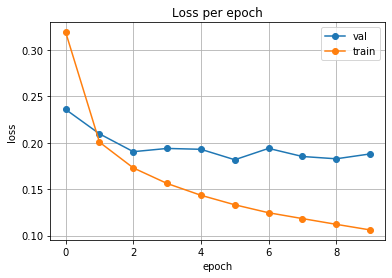

In [25]:
## plot loss by epoch
plt.plot(train_history['val_loss'], label='val', marker='o')
plt.plot( train_history['train_loss'], label='train', marker='o')
plt.title('Loss per epoch'); plt.ylabel('loss');
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()

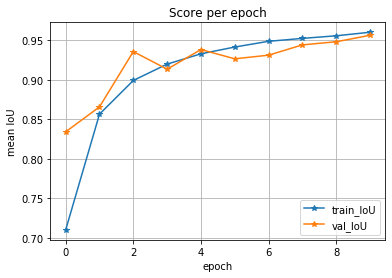

In [26]:
## plot iou score by epoch
plt.plot(train_history['train_iou'], label='train_IoU', marker='*')
plt.plot(train_history['val_iou'], label='val_IoU',  marker='*')
plt.title('Score per epoch'); plt.ylabel('mean IoU')
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()